In [1]:
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox, VBox, Layout
from IPython.display import display, clear_output

#from scripts.mrs_dataloaders import MRSActivityDataset
from torchvision import transforms as T
import matplotlib.pyplot as plt


from scripts.custom_transformations import repeat_color_channel, min_max_normalization, ConvertToUint8, ConvertToFloat32
from scripts.custom_transformations import ConvertToFloat64, sample_frames, PermuteDimensions

In [2]:
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension enable --py ipywidgets

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: contrib dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert nbextensions_configurator notebook run
server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtim

In [3]:
class ClipVisualizer:
    def __init__(self, dataset):
        self.dataset = dataset
        self.num_clips = len(dataset)
        self.current_clip_idx = 0
        self.clip = dataset[self.current_clip_idx]

        self.num_frames = self.clip[0].shape[1]
        self.current_frame = 0

        self.fig, self.ax = plt.subplots()
        
        self.img = self.ax.imshow(self.clip[0][0][self.current_frame])
        self.ax.set_title(f'Clip {self.current_clip_idx + 1}/{self.num_clips}, Frame {self.current_frame + 1}/{self.num_frames}')

        self.bprev_frame = Button(description='Prev Frame')
        self.bprev_frame.on_click(self.prev_frame)

        self.bnext_frame = Button(description='Next Frame')
        self.bnext_frame.on_click(self.next_frame)

        self.bprev_clip = Button(description='Prev Clip')
        self.bprev_clip.on_click(self.prev_clip)

        self.bnext_clip = Button(description='Next Clip')
        self.bnext_clip.on_click(self.next_clip)

        self.jump_10_frames_button = Button(description='Jump 10 Frames')
        self.jump_10_frames_button.on_click(self.jump_10_frames)
       
        self.update_display()

    def update_display(self):
        clear_output(wait=True)
        self.fig.canvas.draw()
        display(self.fig)
        #display(VBox([HBox([self.bprev_clip, self.bprev_frame, self.bnext_frame, self.bnext_clip])]))
        display(HBox([self.bprev_clip, self.bprev_frame, self.bnext_frame, self.bnext_clip, self.jump_10_frames_button]))


    def update_frame(self):
        clear_output(wait=True)
        self.img.set_data(self.clip[0][0][self.current_frame])
        self.ax.set_title(f'Clip {self.current_clip_idx + 1}/{self.num_clips}, Frame {self.current_frame + 1}/{self.num_frames} Action: {self.clip[1]}')
        self.fig.canvas.draw()
        display(self.fig)
        display(HBox([self.bprev_clip, self.bprev_frame, self.bnext_frame, self.bnext_clip,self.jump_10_frames_button]))

    # def start_auto_next_frame(self, event):
    #     if not self.auto_running:
    #         self.auto_running = True
    #         self.auto_next_thread = threading.Thread(target=self.auto_next_frames)
    #         self.auto_next_thread.start()

    # def auto_next_frames(self):
    #     while self.auto_running:
    #         time.sleep(self.fps)  # Wait for 1 second
    #         self.next_frame(None)

    # def stop_auto_next_frame(self):
    #     self.auto_running = False
    #     if self.auto_next_thread is not None:
    #         self.auto_next_thread.join()
    def jump_10_frames(self, event):
        if self.current_frame + 10 < self.num_frames:
            self.current_frame += 10
        else:
            self.current_frame = self.num_frames - 1
        self.update_frame()


    def prev_frame(self, event):
        if self.current_frame > 0:
            self.current_frame -= 1
            self.update_frame()

    def next_frame(self, event):
        if self.current_frame < self.num_frames - 1:
            self.current_frame += 1
            self.update_frame()

    def prev_clip(self, event):
        if self.current_clip_idx > 0:
            self.current_clip_idx -= 1
            self.clip = self.dataset[self.current_clip_idx]
            self.num_frames = self.clip[0].shape[1]
            self.current_frame = 0
            self.update_frame()

    def next_clip(self, event):
        if self.current_clip_idx < self.num_clips - 1:
            self.current_clip_idx += 1
            self.clip = self.dataset[self.current_clip_idx]
            self.num_frames = self.clip[0].shape[1]
            self.current_frame = 0
            self.update_frame()

In [7]:
### Dataloaders for ETRI dataset ###
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import math

# train = 2/3
# val = 1/6
# test = 1/6

class MRSActivityDataset(Dataset):

    def __init__(self, root_dir,max_number_frames, mode = "train" ,transform=None, eval_mode = "cs", get_metadata = False) -> None:
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.labels =[]
        self.clips = []
        self.room = []
        self.edition = []
        self.subjects = []
        self.max_number_frames = max_number_frames
        self.get_metadata = get_metadata
        self.meta_data = {
            "clip_lengths": [],
            "filenames": [],
            "labels": [],}

        self.subject_selector()

        #walk through root_dir and create list of images and labels
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                naming_list = file.split('_')

                action = int(naming_list[0][1:])
                subject = int(naming_list[1][1:])
                edition = int(naming_list[2][1:])

                self.clips.append(os.path.join(root, file))
                self.labels.append(action)
                self.subjects.append(subject)
                self.edition.append(edition)

                if self.get_metadata:
                    #read in the clip and get the length
                    len_current_clip = self.__getitem__(len(self.clips)-1)[0].shape[1]
                    self.meta_data["clip_lengths"].append(len_current_clip)


        print("#########################################")
        print(len(self.clips))
        print("#########################################")
        # print min max and quartiels of clip lengths
        if self.get_metadata:
            print("min clip length: ", np.min(self.meta_data["clip_lengths"]))
            print("25th percentile: ", np.percentile(self.meta_data["clip_lengths"], 25))
            print("50th percentile: ", np.percentile(self.meta_data["clip_lengths"], 50))
            print("75th percentile: ", np.percentile(self.meta_data["clip_lengths"], 75))
            print("max clip length: ", np.max(self.meta_data["clip_lengths"]))

            #save clip lengths to file
            np.save("/data2/fhuemer/MSRActivity3D/metadata/clip_lengths.npy", self.meta_data["clip_lengths"])

       
   
    def subject_selector(self):
        subjects = list(range(1,10))
        if self.mode == "train": 
            #leave out every third subject
            self.chosen_subjects = [x for x in subjects if x % 3 != 0]
        elif self.mode == "test":
            raise NotImplementedError
            self.chosen_subjects = subjects[2::3]
        elif self.mode == "val":
            self.chosen_subjects = subjects[2::3]

    def repeat_or_cutoff(self, clip):
        #repeat or cut off frames to max_number_frames
        if clip.shape[0] < self.max_number_frames:
            clip = np.repeat(clip, math.ceil(self.max_number_frames/clip.shape[0]) + 1 , axis=0)
            clip = clip[:self.max_number_frames, :, :, :]
        elif clip.shape[0] > self.max_number_frames:
            clip = clip[:self.max_number_frames, :, :, :]
        return clip

    def __len__(self):
        return len(self.clips)

    def __getitem__(self, idx):
        # returns sample and label for index 
        clip_path = self.clips[idx]
        label = self.labels[idx]
        clip = load_depth_map(clip_path)

        #add chanel dimension
        clip = np.expand_dims(clip, axis=3)

        #repeat or cut off frames to max_number_frames to get even number of frames
        clip = self.repeat_or_cutoff(clip)
        
        #here the dimensons get rearranged to fit the pytorch format. Watch out! 
        if self.transform:
            clip = self.transform(clip)

        return clip, label 

def     read_header(file):
    # Read the number of frames
    num_frames = np.frombuffer(file.read(4), dtype=np.uint32)[0]
    # Read the dimensions of the frames
    dims = np.frombuffer(file.read(8), dtype=np.uint32)
    return dims, num_frames

def load_depth_map(path):
    with open(path, 'rb') as file:
        # Read header
        dims, num_frames = read_header(file)
        # Read the rest of the file data as uint32
        file_data = np.fromfile(file, dtype=np.uint32)
    
    # Convert to depth map format
    depth_count_per_map = np.prod(dims)
    depth_maps = []

    for _ in range(num_frames):
        current_depth_data = file_data[:depth_count_per_map]
        file_data = file_data[depth_count_per_map:]
        depth_map = current_depth_data.reshape((dims[1], dims[0])).T
        depth_maps.append(depth_map)

    depth_maps = np.stack(depth_maps, axis=0)
    return depth_maps






train_transform = T.Compose([
    min_max_normalization(scale_up=False),
    ConvertToFloat32(),
    PermuteDimensions(order=[3, 0, 1, 2]),
    repeat_color_channel(),
    sample_frames(nth=1),
])
train_set =  MRSActivityDataset(
    root_dir=r"/data/fhuemer/MSRActivity3D/data",
    mode = "train",
    transform=train_transform,
    max_number_frames = 200,

)
train_set.__getitem__(0)[0].shape

#########################################
320
#########################################


In [33]:
#compose_transformations 
train_transform = T.Compose([
    #min_max_normalization(scale_up=True),
    ConvertToFloat32(),
    PermuteDimensions(order=[3, 0, 1, 2]),
    #PermuteDimensions(order=[0, 3, 1, 2]),
    repeat_color_channel(),
    sample_frames(nth=1),
])

train_set =  MRSActivityDataset(
    root_dir=r"/data/fhuemer/MSRActivity3D/data",
    mode = "train",
    transform=train_transform,
    max_number_frames = 200,
)


#########################################
320
#########################################


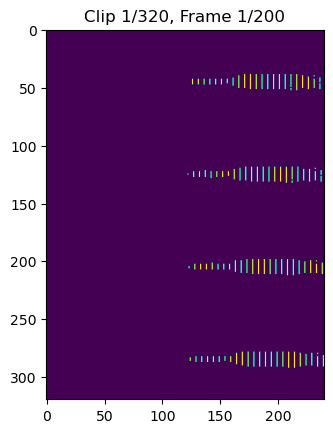

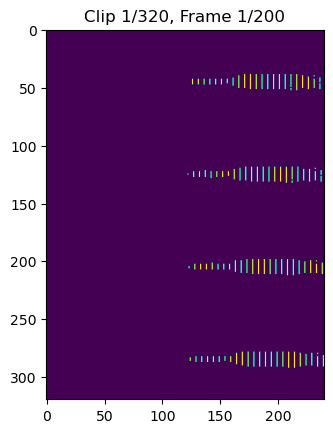

In [37]:
visualizer = ClipVisualizer(train_set)

In [25]:
train_set.__getitem__(0)[0].max(axis=1)

torch.return_types.max(
values=tensor([[[   0.,    0., 3087.,  ..., 2580., 2599., 2580.],
         [   0.,    0., 3059.,  ..., 2580., 2560., 2599.],
         [   0.,    0., 3059.,  ..., 3087., 2580., 2230.],
         ...,
         [2810., 3059., 3033.,  ..., 2599., 2560.,    0.],
         [2788., 3059., 2980.,  ..., 2619., 2580.,    0.],
         [2788., 3087., 2980.,  ..., 2599., 2580.,    0.]],

        [[   0.,    0., 3087.,  ..., 2580., 2599., 2580.],
         [   0.,    0., 3059.,  ..., 2580., 2560., 2599.],
         [   0.,    0., 3059.,  ..., 3087., 2580., 2230.],
         ...,
         [2810., 3059., 3033.,  ..., 2599., 2560.,    0.],
         [2788., 3059., 2980.,  ..., 2619., 2580.,    0.],
         [2788., 3087., 2980.,  ..., 2599., 2580.,    0.]],

        [[   0.,    0., 3087.,  ..., 2580., 2599., 2580.],
         [   0.,    0., 3059.,  ..., 2580., 2560., 2599.],
         [   0.,    0., 3059.,  ..., 3087., 2580., 2230.],
         ...,
         [2810., 3059., 3033.,  ..., 2